# Lecture 11: Dijkstra's algorithm 

In [1]:
from graphStuff import *
from random import random
from random import choice
import heapdict as heapdict # you will need to install heapdict to use this
import time

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Test graph:

Here's the graph that is the running example on the slides

In [2]:
# make a random graph
# This is G(n,p), where we have n vertices and each (directed) edge is present with probability p.
# if you pass in a set of weights, then the weights are chosen uniformly from that set.
# otherwise all weights are 1
def randomGraph(n,p,wts=[1]):
    G = CS161Graph()
    V = [ CS161Vertex(x) for x in range(n) ]
    for v in V:
        G.addVertex(v)
    for v in V:
        for w in V:
            if v != w:
                if random() < p:
                    G.addDiEdge(v,w,wt=choice(wts))
    return G

## BFS for shortest paths

(This is the code we had last time; I've modified it slightly to recover the actual paths)

In [3]:
def BFS(w, G):
    for v in G.vertices:
        v.status = "unvisited"
    n = len(G.vertices)
    Ls = [ [] for i in range(n) ]
    Ls[0] = [w]
    w.status = "visited"
    for i in range(n):
        for u in Ls[i]:
            for v in u.getOutNeighbors():
                if v.status == "unvisited":
                    v.status = "visited"
                    v.parent = u # this is new from Lecture 9: it's a bit of extra bookkeeping to find the shortest paths later
                    Ls[i+1].append(v)
    return Ls

In [4]:
# Here's how we'd actually print out shortest paths.
def BFS_shortestPaths(w,G):
    Ls = BFS(w,G)
    # okay, now what are all the shortest paths?
    for i in range(len(Ls)):
        print("distance", i)
        for w in Ls[i]:
            path = []
            current = w
            for j in range(i):
                path.append(current)
                current = current.parent
            path.append(current)
            path.reverse()
            print([ str(v) for v in path ])
        

In [5]:
# test on a random graph
G = randomGraph(5,.2)
print(G)
BFS_shortestPaths(G.vertices[0],G)

CS161Graph with:
	 Vertices:
	0,1,2,3,4,
	 Edges:
	(0,2; wt:1) (3,0; wt:1) (3,1; wt:1) (3,4; wt:1) 

distance 0
['0']
distance 1
['0', '2']
distance 2
distance 3
distance 4


## Dijkstra's algorithm for shortest paths

BFS only works on unweighted graphs.  Dijkstra's algorithm will work on weighted graphs.

In [6]:
# first let's implement this with an array.
def dijkstraDumb(w,G):
    for v in G.vertices:
        v.estD = math.inf
    w.estD = 0
    unsureVertices = G.vertices[:]
    while len(unsureVertices) > 0:
        # find the u with the minimum estD in the dumbest way possible
        u = None
        minD = math.inf
        for x in unsureVertices:
            if x.estD < minD:
                minD = x.estD
                u = x
        if u == None:
            # then there is nothing more that I can reach
            return
        # update u's neighbors
        for v,wt in u.getOutNeighborsWithWeights():
            if u.estD + wt < v.estD:
                v.estD = u.estD + wt
                v.parent = u
        unsureVertices.remove(u)
    # that's it!  Now each vertex holds estD which is its distance from w

In [7]:
def dijkstraDumb_shortestPaths(w,G):
    dijkstraDumb(w,G)
    # okay, now what are all the shortest paths?
    for v in G.vertices:
        if v.estD == math.inf:
            print("Cannot reach " + str(v))
            continue
        path = []
        current = v
        while current != w:
            path.append(current)
            current = current.parent
        path.append(current)
        path.reverse()
        print([ str(x) for x in path ])

In [11]:
# test on a random graph
G = randomGraph(5,.2)
print(G)
dijkstraDumb_shortestPaths(G.vertices[0], G)

CS161Graph with:
	 Vertices:
	0,1,2,3,4,
	 Edges:
	(1,3; wt:1) (2,1; wt:1) (3,0; wt:1) (3,1; wt:1) (4,3; wt:1) 

['0']
Cannot reach 1
Cannot reach 2
Cannot reach 3
Cannot reach 4


In [13]:
# now let's try this with a heap
def dijkstra(w,G):
    for v in G.vertices:
        v.estD = math.inf
    w.estD = 0
    unsureVertices = heapdict.heapdict()
    for v in G.vertices:
        unsureVertices[v] = v.estD
    while len(unsureVertices) > 0:
        # find the u with the minimum estD, using the heap
        u, dist = unsureVertices.popitem() 
        if u.estD == math.inf:
            # then there is nothing more that I can reach
            return
        # update u's neighbors
        for v,wt in u.getOutNeighborsWithWeights():
            if u.estD + wt < v.estD:
                v.estD = u.estD + wt
                unsureVertices[v] = u.estD + wt #update the key in the heapdict
                v.parent = u
    # that's it!  Now each vertex holds estD which is its distance from w

In [14]:
def dijkstra_shortestPaths(w,G):
    dijkstra(w,G)
    # okay, now what are all the shortest paths?
    for v in G.vertices:
        if v.estD == math.inf:
            print("Cannot reach " + str(v))
            continue
        path = []
        current = v
        while current != w:
            path.append(current)
            current = current.parent
        path.append(current)
        path.reverse()
        print([ str(x) for x in path ])

In [15]:
# test on a random graph
G = randomGraph(5,.4,[1,2,3,4,5])
print(G)
dijkstra_shortestPaths(G.vertices[0], G)

CS161Graph with:
	 Vertices:
	0,1,2,3,4,
	 Edges:
	(0,1; wt:3) (2,3; wt:4) (2,4; wt:1) (4,1; wt:1) 

['0']
['0', '1']
Cannot reach 2
Cannot reach 3
Cannot reach 4


## BFS vs Dijkstra

In [16]:
# generate a bunch of random graphs and run an alg to compute shortest paths (implicitly)  
def runTrials(myFn, nVals, pFn, numTrials=25):
    nValues = []
    tValues = []
    for n in nVals:
        # run myFn several times and average to get a decent idea.
        runtime = 0
        for t in range(numTrials):
            G = randomGraph(n, pFn(n))  #Random graph on n vertices with about pn^2 edges
            start = time.time()
            myFn( G.vertices[0], G ) 
            end = time.time()
            runtime += (end - start) * 1000 # measure in milliseconds
        runtime = runtime/numTrials
        nValues.append(n)
        tValues.append(runtime)
    return nValues, tValues

In [17]:
def smallFrac(n):
    return float(5/n)
nValues = [10,50,100,150,200,300,400,500,700,1000,1200,1400,1600]
nBFS, tBFS = runTrials(BFS, nValues,smallFrac)
nDijkstraDumb, tDijkstraDumb = runTrials(dijkstraDumb, nValues,smallFrac)
nDijkstra, tDijkstra = runTrials(dijkstra, nValues,smallFrac)

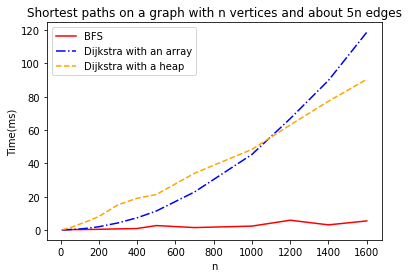

In [18]:
plt.plot(nBFS, tBFS, color="red", label="BFS")
plt.plot(nDijkstraDumb, tDijkstraDumb, "-.", color="blue", label="Dijkstra with an array")
plt.plot(nDijkstra, tDijkstra, "--", color="orange", label="Dijkstra with a heap")
plt.xlabel("n")
plt.ylabel("Time(ms)")
plt.legend()
plt.title("Shortest paths on a graph with n vertices and about 5n edges")
plt.show()